In [13]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [14]:
# include_top = False -> 不包含腦袋(MLP1部分)
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
import glob
import pandas as pd
# 先不讀取圖片, 真的要訓練才讀
df = pd.DataFrame(columns=["path", "target"])
for p in glob.glob("train/cat.*.jpg"):
    s = pd.Series([p, 0], index=["path", "target"])
    df = df.append(s, ignore_index=True)
for p in glob.glob("train/dog.*.jpg"):
    s = pd.Series([p, 1], index=["path", "target"])
    df = df.append(s, ignore_index=True)
df

,path,target
0,train\cat.0.jpg,0
1,train\cat.1.jpg,0
2,train\cat.10.jpg,0
3,train\cat.100.jpg,0
4,train\cat.1000.jpg,0
...,...,...
24995,train\dog.9995.jpg,1
24996,train\dog.9996.jpg,1
24997,train\dog.9997.jpg,1
24998,train\dog.9998.jpg,1


train\cat.2716.jpg
(360, 243)


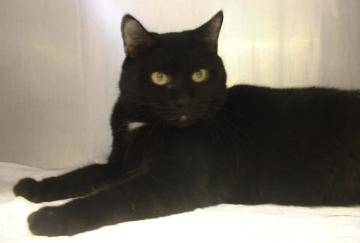

In [16]:
from keras.preprocessing.image import load_img
import random
c = random.randint(0, 24999)
print(df["path"][c])
img = load_img(df["path"][c])
print(img.size)
img

(224, 224)


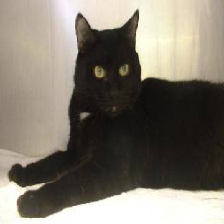

In [17]:
img = load_img(df["path"][c], target_size=(224, 224))
print(img.size)
img

In [27]:
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization
# CNN(眼睛), 在VGG時, 不訓練
for l in vgg.layers:
    l.trainable = False
# BN(血管), BatchNormalization()還是一個算式, 適應前面CNN, 不然會遇到relu死區
x = BatchNormalization()(vgg.output)
# MLP(大腦), Flattern()還是一個算式
x = Flatten()(x)
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
# 貓和狗分類: units = 1, units = 2 都可以
#           :  sigmoid , softmax
x = Dense(units=2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
# vgg.layers[0]取出第一層, vgg.layers[-1]取出最後一層
vgg.layers

In [29]:
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [30]:
# 先處理一下答案, 把它轉化成為one-hot
from keras.utils.np_utils import to_categorical
y_cat = to_categorical(df["target"])

# 真的要開始切分和訓練的時候, 請你把你的pandas轉成numpy的array
from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(y_cat),
                                                    test_size=0.1)
# show一個y_train給你看
y_train[-1]

array([0., 1.], dtype=float32)

In [42]:
# 你偷誰的模型, 就要使用他的預處理方式
from keras.applications.vgg16 import preprocess_input
batch_size = 20
for i in range(5):
    # randint(下限(包括), 上限(不包括), 幾個)
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    # numpy好用之處: array[ 索引list ]
    imglist = []
    for fn in x_train[idx]:
        # 讀取圖片並且使用我們偷來的模型的預處理方式來處理一下
        img = load_img(fn, target_size=(224, 224))
        # 你偷誰的模型, 就要使用他的預處理方式
        img = preprocess_input(np.array(img))
        imglist.append(img)
    x = np.array(imglist)
    y = y_train[idx]
    result = cnn.train_on_batch(x, y)
    print("-----Times", i, "-----")
    # 印出損失率, 準確率
    print(result)

-----Times 0 -----
[1.0998262, 0.9]
-----Times 1 -----
[0.65598476, 0.95]
-----Times 2 -----
[1.3709068e-07, 1.0]
-----Times 3 -----
[0.80590475, 0.95]
-----Times 4 -----
[1.1920929e-07, 1.0]


In [43]:
batch_size = 100

# randint(下限(包括), 上限(不包括), 幾個)
idx = np.random.randint(0, x_test.shape[0], batch_size)
# numpy好用之處: array[ 索引list ]
imglist = []
oriimglist = []
for fn in x_test[idx]:
    # 讀取圖片並且使用我們偷來的模型的預處理方式來處理一下
    img = load_img(fn, target_size=(224, 224))
    # 先把原圖留下來 
    oriimglist.append(np.array(img))
    # 預處理
    img = preprocess_input(np.array(img))
    imglist.append(img)
x = np.array(imglist)
y = y_test[idx]
# 不用訓練了, 直接算
cnn.evaluate(x, y)


100/100 [==============================] - 18s 183ms/step


[0.5261285415291787, 0.96]

In [45]:
# 作圖(參考)
# model無predic_classes, 所以需要自己找
pre = cnn.predict(x).argmax(axis=-1)
# 拿出預測標籤最大值的索引
pre

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [46]:
# 拿出正確答案最大值的索引
y.argmax(axis=-1)

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int64)

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
# 注意此處不是機率, 要找索引值
idx = np.nonzero(pre != y.argmax(axis=-1))[0]
width = 5
height = int(len(idx) / 5) + 1
plt.figure(figsize=(14, 6))
for (i, img) in enumerate(np.array(oriimglist)[idx]):
    plt.subplot(height, width, i + 1)
    t = "[P]:" + str(pre[idx][i]) + "[O]:" + str(y.argmax(axis=-1)[idx][i])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)

array([36, 53, 79, 95], dtype=int64)